# Import pakcages

In [ ]:
!pip install pyLDAvis

ERROR: Operation cancelled by user


In [ ]:
!pip install striprtf

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import gensim
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from striprtf.striprtf import rtf_to_text
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import chain
import string
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models.phrases import Phrases, Phraser
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import contractions
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import LdaModel
import random
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Testing LDA model on English Modern

# Data preprocessing

### Functions

In [ ]:
def get_files(root_dir):
  # Define a list to store the text from .rtf files
  file_list = []

  # Recursively search for files in the root directory and its subdirectories
  for subdir, dirs, files in os.walk(root_dir):
      for fil in files:
          obj = {}
          file_path = os.path.join(subdir, fil)
          seg = subdir.split('/')
          obj['term'] = seg[-1]
          f = open(file_path, 'r')
          text = f.read()
          obj['text'] = text
          f.close
          file_list.append(obj)
  return file_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def extract_doc (file_list):
  regex_pattern = "(.*?)Database:"
  doc_list = []
  for obj in file_list:
    matches = re.finditer(regex_pattern, obj['text'], re.DOTALL)
    for mat in matches:
      doc = {}
      extracted_text = mat.group(1).strip()
      doc['text'] = extracted_text
      doc['term'] = obj['term']
      doc_list.append(doc)
  return doc_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def extract_full_text(doc_list):
  cont_list = []
  pattern0 = r"Full text:(.*?)Location:"
  pattern1 = r"document ID:(.*?)\n"
  pattern2 = r"Source type:(.*?)\n"
  pattern3 = r"Publication date:(.*?)\n"
  pattern4 = r"^.*?Subject:.*?$"
  pattern5 = r"^.*?Business indexing term:.*?$"
  subject_pattern = r"Subject:(.*?)\n"
  subject = ["NA"]
  source = "NA"
  date = "NA"
  for doc in doc_list:
    t = {}
    m0 = re.search(pattern0, doc['text'], re.DOTALL)
    cont = m0.group(1).strip()
    m1 = re.search(pattern1, doc['text'], re.DOTALL)
    id = m1.group(1).strip()
    m2 = re.search(pattern2, doc['text'], re.DOTALL)
    if m2:
      source = m2.group(1).strip()
    m3 = re.search(pattern3, doc['text'], re.DOTALL)
    if m3:
      date = m3.group(1).strip()
    m6 = re.search(subject_pattern, doc['text'], re.DOTALL)
    if m6:
      subject = m6.group(1).strip()
      subject = subject.split("; ")
    m4 = re.search(pattern4, cont, re.DOTALL)
    m5 = re.search(pattern5, cont, re.DOTALL)
    if m5:
      cont = re.sub(pattern5, "", cont, flags=re.MULTILINE)
    if m4:
      cont = re.sub(pattern4, "", cont, flags=re.MULTILINE)
    t['term'] = doc['term']
    t['full_text'] = cont
    t['date'] = date
    t['source'] = source
    t['id'] = id
    t['subject'] = subject
    file_name = source + "_" + doc['term'] + "_" + date + "_" + id
    print(file_name)
    cont_list.append(t)
  return cont_list



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rm_duplicates(cont_list):
  unique_data = []
  seen_texts = set()
  for entry in cont_list:
      full_text = entry['full_text'][:100]
      if full_text not in seen_texts:
          unique_data.append(entry)
          seen_texts.add(full_text)
  return unique_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def remove_links(text):
    pattern = r'\( https?://[^\s()]+ \)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rm_contractions (text_list):
  expanded_doc = [contractions.fix(text['full_text']) for text in text_list]
  return expanded_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def remove_short_and_long_words(nested_list, min_length=3, max_length=15):
    filtered_list = []

    for sublist in nested_list:
        filtered_sublist = [word for word in sublist if min_length <= len(word) <= max_length]
        filtered_list.append(filtered_sublist)

    return filtered_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def text_clean_punctuation(text_list):
  cleaned_list = []
  for text in text_list:
    cleaned = text.replace('\n', ' ').replace("\\", "").replace(' - ', '-').replace('"', ' ')
    punctuation = string.punctuation.replace('-', '').replace("'",'')
    no_punctuation = cleaned.translate(str.maketrans('', '', punctuation))
    cleaned_list.append(no_punctuation)
  return cleaned_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def stemming(text_list):
  stemmer = PorterStemmer()
  stemmed_documents = [[stemmer.stem(word) for word in doc] for doc in text_list]
  return stemmed_documents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def tokenize_rm_stopwords(text_list):
  stop_words = stopwords.words('english')
  texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_list]
  return texts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def lemmatize_doc(doc):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []

    for sublist in doc:
        lemmatized_sublist = []
        i = 0
        for token in sublist:
          # Lemmatize nouns
          for arg in ['n', 'v', 'a', 'r']:
            token = lemmatizer.lemmatize(token, pos=arg)
          lemmatized_sublist.append(token)
        lemmatized_list.append(lemmatized_sublist)
        # for token, lemma in zip(sublist, lemmatized_sublist):
        #   if i < 10:
        #     print(f"{token} --> {lemma}")
        #   else:
        #     break
        #   i += 1
    return lemmatized_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def add_bigram(lemma_doc, min_count=10):
  bigram = Phrases(lemma_doc, min_count = min_count)
  bigram_doc = [bigram[doc] for doc in lemma_doc]
  return bigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def add_trigram(bigram_doc, min_count=10):
  trigram = Phrases(bigram_doc, min_count = min_count)
  trigram_doc = [trigram[doc] for doc in bigram_doc]
  return trigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rm_key_term (trigram_doc, word_list):
  result = [[word for word in doc if word not in word_list]for doc in trigram_doc]
  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import data

In [ ]:
root_dir = '/content/drive/MyDrive/audace_trial/corpus/english_modern'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
file_list = get_files(root_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data cleaning

In [ ]:
doc_list = extract_doc(file_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cont_list = extract_full_text(doc_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Blog, Podcast, or W ebsite_flood_Sep 29, 2020_2447104249
Wire Feed_flood_Sep 28, 2020_2447365132
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447063451
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447062092
Blog, Podcast, or Website_flood_May 14, 2020_2402597693
Blog, Podcast, or Website_flood_May 8, 2020_2400120923
Blog, Podcast, or Website_flood_Apr 3, 2020_2385834748
Blog, Podcast, or Website_flood_Apr 2, 2020_2385831916
Blog, Podcast, or Website_flood_Apr 2, 2020_2385821376
Blog, Podcast, or Website_flood_Apr 2, 2020_2385757794
Blog, Podcast, or Website_flood_Mar 28, 2020_2383923470
Blog, Podcast, or Website_flood_Mar 13, 2020_2376983539
Newspaper_flood_Feb 12, 2020_2353875312
Blog, Podcast, or Website_flood_Feb 12, 2020_2353761600
Blog, Podcast, or Website_flood_Feb 11, 2020_2353746300
Newspaper_flood_Feb 6, 2020_2351863810
Newspaper_flood_Feb 1, 2020_2349709274
Blog, Podcast, or Website_flood_Jan 31, 2020_2349784146
Blog, Podcast, or Website_flood_Nov 1, 2019_2311264289
Blog,

In [ ]:
len(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2737

In [ ]:
unique_list = rm_duplicates(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1559

In [ ]:
exp_list = rm_contractions(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cleaned_content = text_clean_punctuation(exp_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tokenized_doc = tokenize_rm_stopwords(cleaned_content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_doc = remove_short_and_long_words(tokenized_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lemma_doc = lemmatize_doc(filtered_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# keywords = ['flood', 'blizzard', 'snow', 'heat_wave', 'rain', 'fire', 'heat', 'wave']
# lemma_doc = rm_key_term(lemma_doc, keywords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bigram_doc = add_bigram(lemma_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trigram_doc = add_trigram(bigram_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
random.shuffle(trigram_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


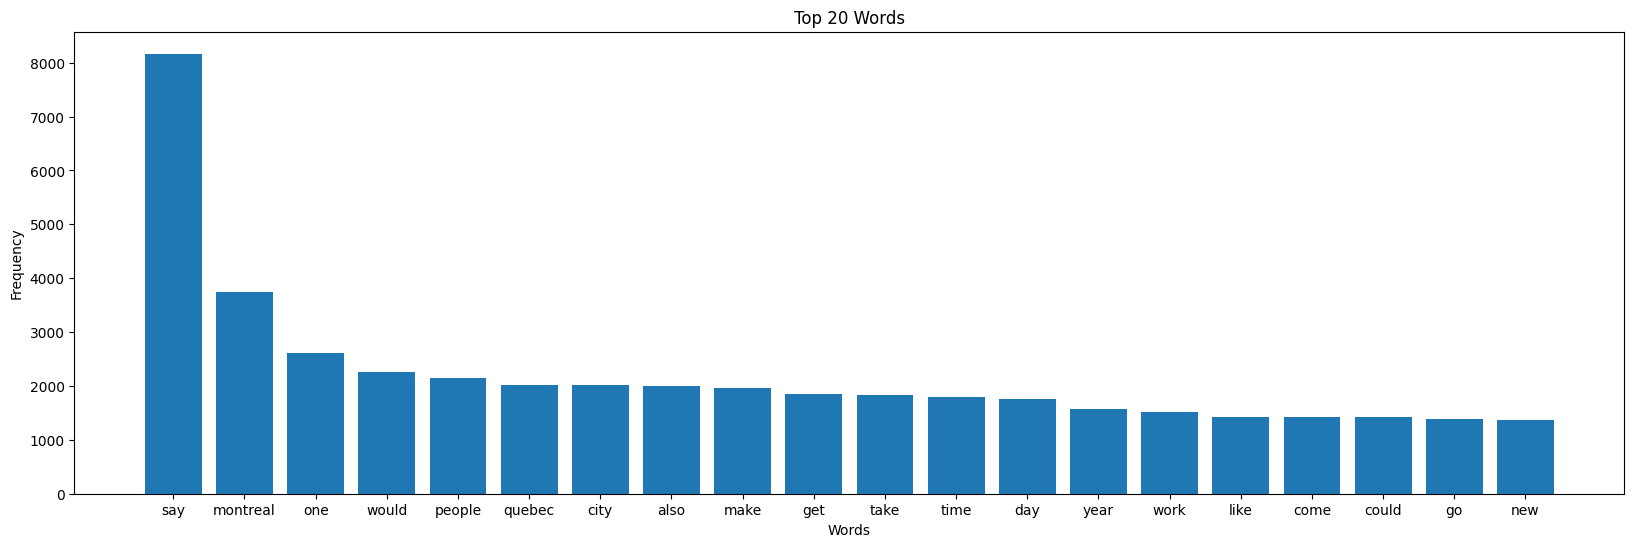

In [ ]:
words = trigram_doc

flat_words = list(chain.from_iterable(words))

word_counts = Counter(flat_words)

top_words = word_counts.most_common(20)

labels, values = zip(*top_words)
plt.figure(figsize=(20, 6))
plt.bar(labels, values)
plt.title("Top 20 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.show()

## Create corpus and dictionary

In [ ]:
# Create dictionary and corpus
texts = trigram_doc
dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3560
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Genism LDA model

## Select number of topics: K

In [ ]:
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

In [ ]:
max_num = 50

### cv coherence score

In [ ]:
coherence_scores_cv = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cv.append(coherence_lda)

NameError: ignored

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cv)
plt.title("The coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cv_scores.png")

### umass coherence score

In [ ]:
coherence_scores_umass = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='u_mass')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_umass.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_umass)
plt.title("The umass coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_umass_scores.png")

### c_uci coherence score

In [ ]:
coherence_scores_cuci = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_uci')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cuci.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cuci)
plt.title("The cuci coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cuci_scores.png")

### c_npmi coherence score

In [ ]:
coherence_scores_cnpmi = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_npmi')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cnpmi.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cnpmi)
plt.title("The cnpmi coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cnpmi_scores.png")

### select k

In [ ]:
k = coherence_scores_cv.index(max(coherence_scores_cv))+1

In [ ]:
k

## Training

In [ ]:
k=14

In [ ]:
num_topics = k
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
coherence_lda = coherence_model_lda.get_coherence()
print("The score is ", coherence_lda)

In [ ]:
while coherence_lda < 0.45:
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print("The score is ", coherence_lda)

In [ ]:
top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / k
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
# get the topic-term matrix
topic_terms = lda_model.get_topics()

# number of top words to consider for each topic
topn = 10

# print top words for each topic and assign a label
for i in range(lda_model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i+1}: {', '.join(top_words)}")

In [ ]:
topic_keywords = lda_model.show_topics(num_topics=-1, num_words=20)

In [ ]:
for topic in topic_keywords:
    print(f"Topic {topic[0]}: {topic[1]}")

In [ ]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

In [ ]:
pyLDAvis.save_html(vis_data, 'lda_' + str(k) + 'topics.html')

## Save model

In [ ]:
lda_model.save("/content/drive/MyDrive/audace_trial/model/lad_models/lda_model_0.4509_06_27.lda")

# Classification


In [ ]:
model = LdaModel.load("/content/drive/MyDrive/audace_trial/model/lad_models/lda_model_0.4412_06_14.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data = gensimvis.prepare(model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
topic_distributions = model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get the topic-term matrix
topic_terms = model.get_topics()

# number of top words to consider for each topic
topn = 10

# print top words for each topic and assign a label
for i in range(model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i}: {', '.join(top_words)}")

Topic 0: permit, suit, north_montreal, stephen, item, reason, tire, heat-related_death, fire, ago
Topic 1: queen, pay, short, dump, fit, none, live, daytime_high, best, advisory
Topic 2: except, completely, pay, episode, recommend, queen, cold, 2015, household, simply
Topic 3: contract, snow_fall, hire, canadian, detail, fire, none, vehicle, heat-related_death, pay
Topic 4: queen, quebecers, fit, europe, tender, today, labour, none, early, nothing
Topic 5: federal_government, cold, various, quite, car, exit, top, hot_weather, vehicle, modern
Topic 6: contract, fear, stephen, properly, instead, canadian, emergency, dump, measure, permit
Topic 7: ensure, widespread, make_sure, break_news_visit, none, travel, sorry, rise, across_province, employee
Topic 8: fell, expert, none, best, break_news_visit, big, rise, pay, dump, trace
Topic 9: pay, hail, environment_canada, homeowner, queen, widespread, retirement, report, map, stop
Topic 10: widespread, reach, noon, simple, admission, trick, veh

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_labels = {
    0: "Sports",
    1: "Education and Society",
    2: "Natural Disasters (Floods, Fires)",
    3: "Dining and Restaurants",
    4: "Politics and Government",
    5: "Weather report",
    6: "General Interests and Activities",
    7: "Urban Planning and Infrastructure (Climate change related)",
    8: "Business and Economy",
    9: "Heatwave and Public Safety",
    10: "Winter Maintenance (Snow Removal)",
    11: "Winter Storms and Road Conditions",
    12: "Seasons and Outdoor Activities",
    13: "Parks and Wildlife"
    # Add labels for other topics
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for topic_id in range(model.num_topics):
    top_words = model.show_topic(topic_id, topn=10)  # Get top 10 words for the topic
    label = topic_labels.get(topic_id, f"Topic {topic_id}")  # Get the label or use default label
    print(f"{label}:")
    for word, prob in top_words:
        print(f"{word}: {prob}")
    print()

Sports:
game: 0.02584872767329216
canadiens: 0.019191065803170204
season: 0.014215071685612202
play: 0.014138225466012955
team: 0.009820329956710339
goal: 0.00841460283845663
score: 0.007830203510820866
two: 0.007152835838496685
good: 0.006953490432351828
player: 0.006915601901710033

Education and Society:
quebec: 0.01879182830452919
people: 0.00860483106225729
school: 0.007505756802856922
work: 0.005917139817029238
government: 0.0055680908262729645
new: 0.005428192671388388
many: 0.005115063861012459
case: 0.005031872075051069
canada: 0.004918180871754885
student: 0.004364306572824717

Natural Disasters (Floods, Fires):
flood: 0.02472485788166523
home: 0.013991904444992542
people: 0.009965451434254646
fire: 0.009629100561141968
resident: 0.008612771518528461
quebec: 0.008435261435806751
area: 0.007264676038175821
community: 0.0055213384330272675
help: 0.0051932502537965775
house: 0.004932632204145193

Dining and Restaurants:
like: 0.008674909360706806
restaurant: 0.008249538019299507

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_distributions = model[corpus]

# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    print(f"Document {i+1} topics:")
    for topic_id, topic_prob in doc_topics:
        # Assign the corresponding topic label to the text based on the topic_id
        topic_label = topic_labels[topic_id]
        print(f"Topic {topic_id}: {topic_label} ({topic_prob})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Topic 6: General Interests and Activities (0.30734384059906006)
Topic 7: Urban Planning and Infrastructure (Climate change related) (0.033178217709064484)
Topic 8: Business and Economy (0.13998961448669434)
Topic 9: Heatwave and Public Safety (0.1138683632016182)
Topic 12: Seasons and Outdoor Activities (0.08041097223758698)
Document 1007 topics:
Topic 1: Education and Society (0.16136184334754944)
Topic 2: Natural Disasters (Floods, Fires) (0.06012766808271408)
Topic 3: Dining and Restaurants (0.12313340604305267)
Topic 4: Politics and Government (0.09727004170417786)
Topic 6: General Interests and Activities (0.1408950835466385)
Topic 8: Business and Economy (0.26297008991241455)
Topic 9: Heatwave and Public Safety (0.0488739050924778)
Topic 10: Winter Maintenance (Snow Removal) (0.03245789557695389)
Topic 12: Seasons and Outdoor Activities (0.0499146468937397)
Topic 13: Parks and Wildlife (0.02226424589753151)
Document 1008 topics:


In [ ]:
# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    print(f"Document {i+1} topic: {topic_label} ({topic_prob})")

Document 1 topic: Education and Society (0.673089861869812)
Document 2 topic: Education and Society (0.8072139024734497)
Document 3 topic: Education and Society (0.7062181234359741)
Document 4 topic: Education and Society (0.3750278949737549)
Document 5 topic: Education and Society (0.380008339881897)
Document 6 topic: Education and Society (0.4712406396865845)
Document 7 topic: Heatwave and Public Safety (0.4489091634750366)
Document 8 topic: Heatwave and Public Safety (0.5351864099502563)
Document 9 topic: Education and Society (0.35470589995384216)
Document 10 topic: Heatwave and Public Safety (0.3158806562423706)
Document 11 topic: Education and Society (0.3798162043094635)
Document 12 topic: Education and Society (0.6433525085449219)
Document 13 topic: Education and Society (0.5099709630012512)
Document 14 topic: Education and Society (0.516854465007782)
Document 15 topic: General Interests and Activities (0.46775370836257935)
Document 16 topic: Education and Society (0.2583379745

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Document 37 topic: Heatwave and Public Safety (0.29785165190696716)
Document 38 topic: Business and Economy (0.21343791484832764)
Document 39 topic: General Interests and Activities (0.1962692141532898)
Document 40 topic: General Interests and Activities (0.25069358944892883)
Document 41 topic: Business and Economy (0.3867895305156708)
Document 42 topic: Heatwave and Public Safety (0.4117771089076996)
Document 43 topic: General Interests and Activities (0.5340898633003235)
Document 44 topic: Education and Society (0.25048911571502686)
Document 45 topic: Education and Society (0.3277031481266022)
Document 46 topic: Business and Economy (0.32575637102127075)
Document 47 topic: Education and Society (0.22292880713939667)
Document 48 topic: Education and Society (0.20906560122966766)
Document 49 topic: Business and Economy (0.487323522567749)
Document 50 topic: Heatwave and Public Safety (0.32954952120780945)
Document 51 topic: Seasons and Outdoor Activities (0.3524389863014221)
Document 

In [ ]:
unique_list[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'term': 'flood',
 'full_text': 'QUEBEC - As Quebec health officials scrambled in late summer to prevent a flood of new COVID-19 infections, some doctors and researchers questioned whether the prevention measures would be effective. Now, cases have risen to levels not seen since near the peak of the pandemic.\n"Something is not working in Quebec," said Dr. Nima Machouf, an epidemiologist at l\'Université de Montréal. "When we look at the numbers, we look at Quebec and we compare it to the rest of Canada. In Quebec, it\'s not going well. In Ontario, they\'re a much larger population, but they have half as many patients. "\nThe provincial government\'s response, she and several other experts told the Montreal Gazette on Monday, lacked severity early, when the second wave was still a bump. A failure to prevent private gatherings in early September probably contributed to the new surge in infections, they said, which is prompting the government to institute new, lockdown-like measures in Q

In [ ]:
data = []

# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    # Retrieve the content of the text from unique_list
    text_content = unique_list[i]['full_text']

    # Append the data to the list
    data.append({'Text': text_content, 'Topic Label': topic_label, 'Probability': topic_prob})

# Create the dataframe
df = pd.DataFrame(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,Education and Society,0.673090
1,As Quebec health officials scrambled in late s...,Education and Society,0.807165
2,QUEBEC - The province wants to help Montreal o...,Education and Society,0.706171
3,Within 48 hours of the provincial government s...,Education and Society,0.375116
4,Verdun Hospital has been hit with the most sev...,Education and Society,0.380025
...,...,...,...
1554,Power outages and flight disruptions reported ...,Heatwave and Public Safety,0.227213
1555,? Much of Ontario and large parts of Quebec ar...,General Interests and Activities,0.197795
1556,"Close to 30,000 Quebecers were left without po...",General Interests and Activities,0.256155
1557,Southern Ontario was hit with a winter storm T...,Education and Society,0.253435


In [ ]:
df.to_csv('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_06_27_2023.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


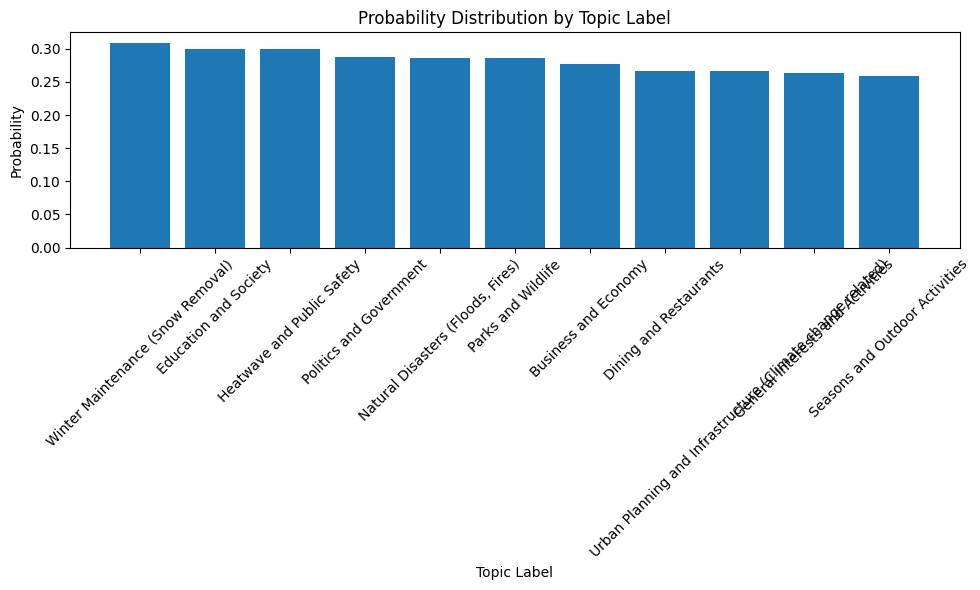

In [ ]:
# Group the dataframe by topic label and calculate the mean probability
grouped_df = df.groupby('Topic Label')['Probability'].mean().reset_index()

# Sort the dataframe by descending probability
grouped_df = grouped_df.sort_values(by='Probability', ascending=False)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Topic Label'], grouped_df['Probability'])
plt.xlabel('Topic Label')
plt.ylabel('Probability')
plt.title('Probability Distribution by Topic Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


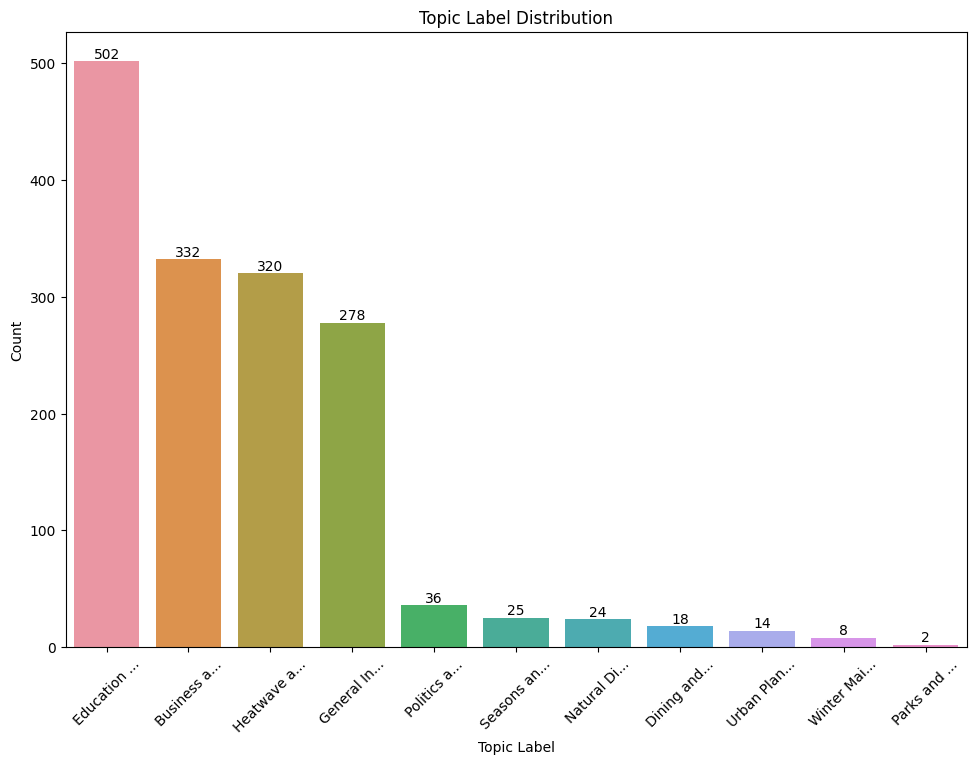

In [ ]:
# Count the occurrences of each topic label
label_counts = df['Topic Label'].value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:10] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()